In [1]:
import sys
# include the toolkit path in the modules paths
sys.path.append('../scripts')

# graphics
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

from IPython.html.widgets import interact

# maths
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import curve_fit

# the opsin-model toolkit
import marco_tools as mt

# plotting constants
FIG_BIG = (15,10)
FIG_H = (15,7)
FIG_SMALL = (7,7)

# help setting the text in a plot
def default_plot_setup(title='Title', xlabel='x',ylabel='y'):
    plt.title(title);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel);


/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/home/marco/miniconda2/envs/condaPy2/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## System definition 

In [2]:
# CONSTANTS DEFINING THE STATES
C = 0   # Closed state
O = 1   # Opens state
D = 2   # Desensitized state

# TRANSITION RATES MATRICES
K_off = np.zeros([3,3]) # transition coefficient MATRIX when light is OFF
K_on =  np.zeros([3,3]) # transition coefficient MATRIX when light is ON


tau_off = 18

tau = tau_off #17.9 # usually called "tauoff" [ms] Exp Physiol. 2011 Jan; 96(1): 19–25. 
k = 1.0/tau

K_off[O,C] = k
K_on[O,C] = k

tau_on = 50
K_on[C,O] = 1.0/tau_on

#K_off[C,O] = 0
#K_on[C,O] = k

#K_off[O,D] = 0
#K_on[O,D] = lightpower*beta

#K_off[D,O] = k/30
#K_on[D,O] = K_off[D,O] # k/30

In [187]:
def ode_model_generic_on_off(y, t, k):
    dy = np.empty_like(y)

    # ODE system
    for i, f in enumerate(y):
        dy[i] = -f * sum(k[i, :]) + np.dot(y, k[:, i])  # short notation for the linear system

    return dy


def der(y,dt,k):
    dy = np.empty_like(y)
    for i, f in enumerate(y):
        dy[i] = -f * sum(k[i, :]) + np.dot(y, k[:, i])
    
    return y + dy*dt


### Bring the pulse outside

In [126]:
simul = {
        "start time" : 0,
        "end time" : 1000,
        "points" : 100,
        "pulse duration" : 300
    }

timespace = np.linspace( simul["start time"], simul["end time"], simul["points"] )
dt = (timespace[-1]-timespace[0])/(len(timespace)-1)


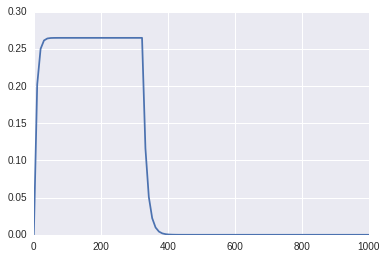

In [188]:
# SOLVE THE DIFFERENTIAL EQUATION SYSTEM with the given parameters

initial_condition = [1,0,0]

# step integration

k = K_on
v = np.zeros((len(timespace) , 3))
v[0] = initial_condition

int_step = 2
for i in range(1,len(timespace)):
    if i==simul["points"]/3:
        k = K_off
#     v[i] = odeint(ode_model_generic_on_off, 
#                v[i-1],
#                np.linspace(0,dt,int_step),
#                tuple([k]),
#                hmax=dt)[-1]
    v[i] = der(v[i-1],dt,k)

plt.plot(timespace, v[:,1]);
# plt.axis((0,1000,0,1.2));

### for 2D

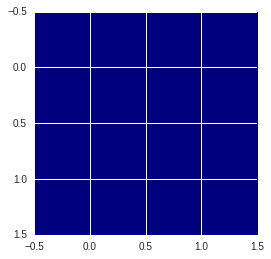

In [189]:
N = 2
A = np.zeros((simul["points"], 3, N, N))

#setting initial condition A[time,population,X,Y]
A[0,0,:,:] = np.ones((N,N))

int_step = 2
k = K_on
# print A[0,1,:]

# j=0
# v = A[0,:, j%N , j/N]
# print v

for i in range(1,len(timespace)):
    if i==simul["points"]/3:
        k = K_on
        
    for j in range(N**2): #scan the 2d matrix
        v = A[:,:, j%N , j/N]
        
#         v[i] = odeint(ode_model_generic_on_off, 
#                    v[i-1],
#                    np.linspace(0,dt,int_step),
#                    tuple([k]),
#                    hmax=dt)[-1]
        v[i] = der(v[i-1],dt,k)

plt.imshow(A[20,1,:,:], cmap='jet')

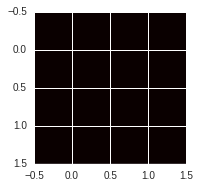

In [183]:
fig = plt.figure()
ax1 = fig.add_subplot(1,2,1)
import pylab

# im1 = ax1.imshow(s0[:,:,0], interpolation = 'none',norm=norm,
#                  extent = [-Xmax, Xmax, -Xmax, Xmax])

norm = pylab.mpl.colors.Normalize(vmin=0, vmax=1)
im1 = ax1.imshow(A[0,1,:,:], interpolation='none', norm = norm, cmap='hot')


def init():
    im1.set_data(A[0,1,:,:])
    return([im1])

                                              
def animate(t):
    im1.set_data(A[t,1,:,:])
    return([im1])

anim = animation.FuncAnimation(fig,
                               animate,
                               simul["points"]-1,
                               interval=20,
                               init_func=init,
                               repeat=True)

# im = plt.imshow(A[0,1,:,:], cmap=plt.get_cmap('jet'))
# ims = []

# for i in range(simul["points"]):
#     im = plt.imshow(A[i,1,:,:])
#     ims.append([im])
    
# ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True)

anim.save("test.avi")
